In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np


In [140]:
save = 'experiments/simple_sgm_dt001_lm/'
dataset = '2spirals'
depth = 7
finalT = 2.0
dt = 0.5
savedir = save + dataset + '_scoredepth' + str(depth) + '_finalT' + str(finalT) + '/'
loadir = savedir + '_scorenet'
scorenet = torch.load(loadir)

In [129]:
def reverse_sde(score, init,T,lr= dt):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def reverse_sde_lm(score, init,T,lr = dt):
    step = int(T/lr)
    lastnoise = torch.randn_like(init)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )

        currentnoise = torch.randn_like(init)

        init = init + (currentnoise + lastnoise)/2 * np.sqrt(current_lr)

        lastnoise = currentnoise


    return init


In [130]:
samples_lang_lm = torch.randn(10000, 2) 
samples_lang_lm = reverse_sde_lm(scorenet, samples_lang_lm,torch.tensor(finalT)).detach().numpy()

samples_lang = torch.randn(10000, 2) 
samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(finalT)).detach().numpy()



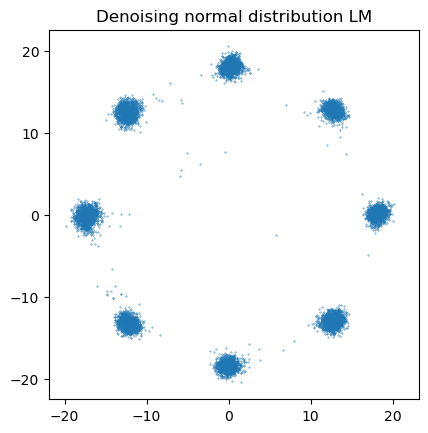

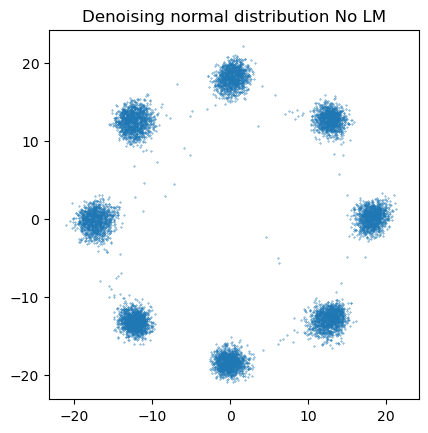

In [131]:
plt.clf()
plt.scatter(samples_lang_lm[:,0],samples_lang_lm[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal distribution LM')
plt.show()

plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title('Denoising normal distribution No LM')
plt.show()

Text(0.5, 1.0, 'True samples')

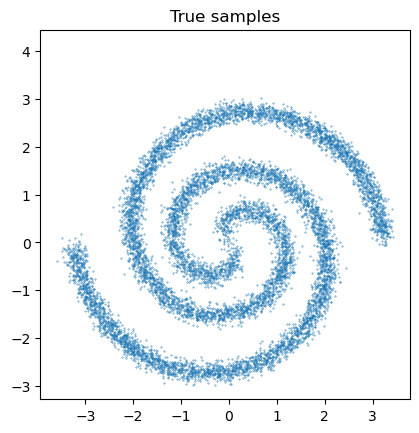

In [141]:
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
plt.title('True samples')